### Assignment 3

#### Task 1 (7 points):

* Download the data (*sonar.all-data*) from the *Sonar, Mines vs. Rocks Data Set*: https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)
* Substitute the categories M and R of the last column for integers.
* Find the best parameters on the validation set using gridsearch (min. 2 parameters) for one model.
* Plot a heatmap of the parameters. Find the best set of parameters. Comment your results.
* Plot a ROC curve. Comment your results.

In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import LeaveOneOut

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Import libraries
%matplotlib inline

plt.rcParams["figure.figsize"] = [16, 9]


In [2]:
# Load dataset
url = "https://people.arcada.fi/~martinel/"
df = pd.read_csv(url + 'sonar.all-data', header=None)

# Encoding R (Rocks) as 0 and M (Mines) as 1
cleanup_values = {60: {"R": 0, "M": 1}}
df = df.replace(cleanup_values)

# Split into input and output elements
data = df.values
X, y = data[:, :-1], data[:, -1]

# Print original, X and y shapes
print(df.shape)
print(X.shape, y.shape)


(208, 61)
(208, 60) (208,)


In [3]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 42)

# Define model
classifier = RandomForestClassifier(random_state=42)

# Define grid params
grid_param = {
    'n_estimators': [100, 300, 500, 800, 1000],
    'criterion': ['gini', 'entropy'],
}

# Cross-validation strategy
loo = LeaveOneOut()

# Define search
grid_search = GridSearchCV(estimator=classifier,
                      param_grid=grid_param,
                      scoring='accuracy',
                      cv=loo,
                      n_jobs=-1)

# Execute search
grid_search.fit(X_train, y_train)

# Summarize result
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print('Best Estimator: %s' % grid_search.best_estimator_)
print('Best Cross-Validation Score: %s' % grid_search.best_score_)
print('Best Hyperparameters: %s' % grid_search.best_params_)

# Convert to DataFrame
results = pd.DataFrame(grid_search.cv_results_)


Test set score: 0.84
Best Estimator: RandomForestClassifier(criterion='entropy', n_estimators=300, random_state=42)
Best Cross-Validation Score: 0.8413793103448276
Best Hyperparameters: {'criterion': 'entropy', 'n_estimators': 300}


<AxesSubplot:xlabel='param_n_estimators', ylabel='param_criterion'>

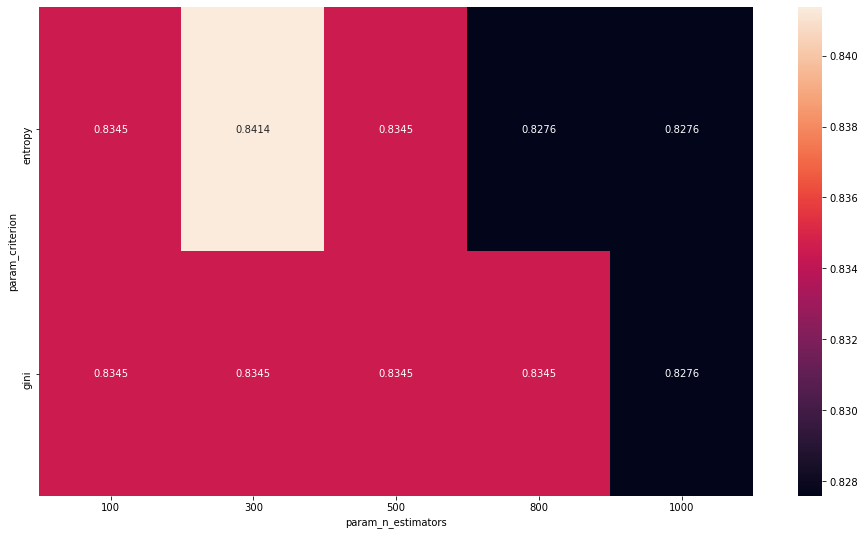

In [4]:
max_scores = results.groupby(['param_criterion', 'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')

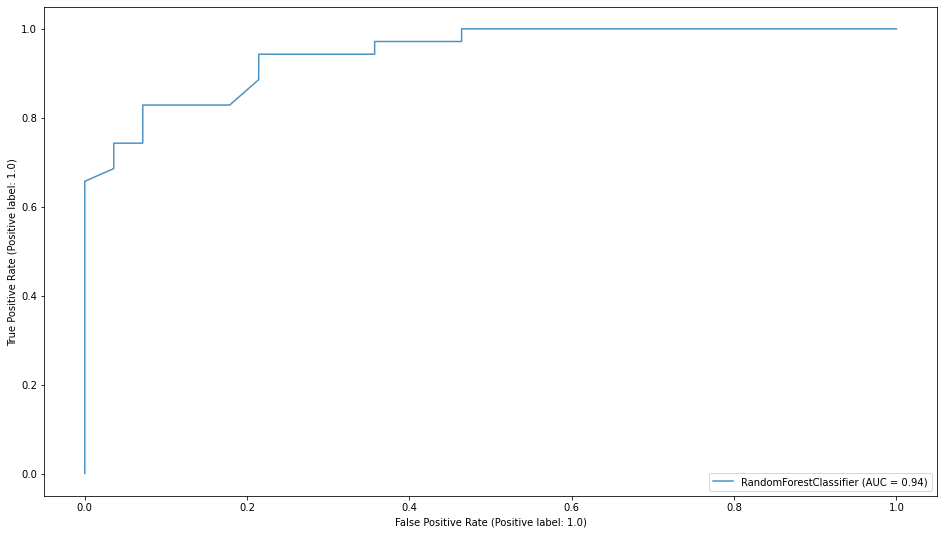

In [5]:
rfc = RandomForestClassifier(n_estimators=300, criterion='entropy', random_state=42)
rfc.fit(X_train, y_train)
ax = plt.gca()
rfc_disp = plot_roc_curve(rfc, X_test, y_test, ax=ax, alpha=0.8)
plt.show()


#### Task 2 (8 points):

Data Set Information:

2126 fetal cardiotocograms (CTGs) were automatically processed and the respective diagnostic features measured. The CTGs were also classified by three expert obstetricians and a consensus classification label assigned to each of them. Classification was both with respect to a morphologic pattern (A, B, C. ...) and to a fetal state (N, S, P). Therefore the dataset can be used either for 10-class or 3-class experiments.

* Download the data from the *Cardiotocography Data Set*: https://archive.ics.uci.edu/ml/datasets/Cardiotocography
* Find the best two models by creating a complete pipeline with different parameters and algorithms. One model should predict the *morphologic pattern* and the other the *fetal state*. 
* Comment on the time and preformance metrics used in each model.

In [6]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import time

In [7]:
# Load dataset
url = "https://people.arcada.fi/~martinel/"
df = pd.read_excel(url + 'CTG.xls', "Raw Data")

columns = ['LB', 'AC', 'FM', 'UC',
            'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS', 'DP', 'DR', 'Width', 'Min',
            'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance',
            'Tendency', 'CLASS', 'NSP']

X_columns = ['LB', 'AC', 'FM', 'UC',
            'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS', 'DP', 'DR', 'Width', 'Min',
            'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance',
            'Tendency'
            ]
            
df = df[columns]
df = df.dropna()
df

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
1,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,...,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,9.0,2.0
2,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,0.0,...,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,6.0,1.0
3,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,0.0,...,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,6.0,1.0
4,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,0.0,...,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,6.0,1.0
5,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,0.0,...,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2122,140.0,0.0,0.0,6.0,79.0,0.2,25.0,7.2,0.0,0.0,...,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,5.0,2.0
2123,140.0,1.0,0.0,9.0,78.0,0.4,22.0,7.1,0.0,0.0,...,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,5.0,2.0
2124,140.0,1.0,0.0,7.0,79.0,0.4,20.0,6.1,0.0,0.0,...,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,5.0,2.0
2125,140.0,1.0,0.0,9.0,78.0,0.4,27.0,7.0,0.0,0.0,...,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,5.0,2.0


In [8]:
# Split the data
X, y = df[X_columns], df['CLASS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
problems = ['CLASS','NSP']

for problem in problems:

	# Split the data
	X, y = df[X_columns], df[problem]
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

	# Construct some pipelines
	pipe_lr = Pipeline([('scl', StandardScaler()),
			('clf', LogisticRegression(random_state=42))])

	pipe_rf = Pipeline([('scl', StandardScaler()),
			('clf', RandomForestClassifier(random_state=42))])

	pipe_svm = Pipeline([('scl', StandardScaler()),
			('clf', svm.SVC(random_state=42))])
			
	# Set grid search params
	param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
	param_range_fl = [1.0, 0.5, 0.1]

	grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
			'clf__C': param_range_fl,
			'clf__solver': ['liblinear']}] 

	grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
			'clf__min_samples_leaf': param_range,
			'clf__max_depth': param_range,
			'clf__min_samples_split': param_range[1:]}]

	grid_params_svm = [{'clf__kernel': ['linear', 'rbf'], 
			'clf__C': param_range}]

	# Construct grid searches
	jobs = -1

	gs_lr = GridSearchCV(estimator=pipe_lr,
			param_grid=grid_params_lr,
			scoring='accuracy',
			cv=10) 
			
	gs_rf = GridSearchCV(estimator=pipe_rf,
			param_grid=grid_params_rf,
			scoring='accuracy',
			cv=10, 
			n_jobs=jobs)

	gs_svm = GridSearchCV(estimator=pipe_svm,
			param_grid=grid_params_svm,
			scoring='accuracy',
			cv=10,
			n_jobs=jobs)

	# List of pipelines for ease of iteration
	grids = [gs_lr, gs_rf, gs_svm]

	# Dictionary of pipelines and classifier types for ease of reference
	grid_dict = {0: 'Logistic Regression', 1: 'Random Forest', 2: 'Support Vector Machine'}

	# Fit the grid search objects
	print('Performing model optimizations...')
	best_acc = 0.0
	best_clf = 0
	best_gs = ''
	fitting_time = 0
	
	for idx, gs in enumerate(grids):
		print('\nEstimator: %s' % grid_dict[idx])	
		start = time.time()
		# Fit grid search	
		gs.fit(X_train, y_train)
		stop = time.time()
		fitting_time = stop - start
		print('Training time: %.3f' %fitting_time, 'sec.')
		# Best params
		print('Best params: %s' % gs.best_params_)
		# Best training data accuracy
		print('Best training accuracy: %.3f' % gs.best_score_)
		# Predict on test data with best params
		y_pred = gs.predict(X_test)
		# Test data accuracy of model with best params
		print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
		# Track best (highest test accuracy) model
		if accuracy_score(y_test, y_pred) > best_acc:
			best_acc = accuracy_score(y_test, y_pred)
			best_gs = gs
			best_clf = idx
			matrix = confusion_matrix(y_test, y_pred)
			report = classification_report(y_test, y_pred)
			fitting_time_best_model = fitting_time

	# Fit grid search
	print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])
	print(f"Training time: {fitting_time_best_model}s")
	print(matrix)
	print(report)

Performing model optimizations...

Estimator: Logistic Regression
Training time: 6.849 sec.
Best params: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.795
Test set accuracy score for best params: 0.786 

Estimator: Random Forest
Training time: 768.817 sec.
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 3}
Best training accuracy: 0.897
Test set accuracy score for best params: 0.883 

Estimator: Support Vector Machine
Training time: 3.984 sec.
Best params: {'clf__C': 10, 'clf__kernel': 'rbf'}
Best training accuracy: 0.844
Test set accuracy score for best params: 0.869 

Classifier with best test set accuracy: Random Forest
Training time: 768.8167741298676s
[[ 65   2   3   0   1   1   1   0   0   0]
 [  2 107   0   0   0   2   3   0   0   0]
 [  3   1   9   0   0   0   0   0   0   0]
 [  0   9   0  10   0   0   0   0   0   0]
 [  2   3   0   0   8   0   1   0   0   3]
 [  